## IMPORTING ALL REQUIRED MODULES

In [46]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt

!pip install scikit-optimize
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from sklearn.pipeline import Pipeline

#Hospital mortality classifier modules
!pip install category_encoders
from category_encoders.target_encoder import TargetEncoder
from xgboost import plot_importance
from xgboost import XGBClassifier
from sklearn.metrics import balanced_accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

#Length of stay prediction modules
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error

# TASK 1: PREDICTING MORTALITY

## 1) Importing data

In [47]:
test = pd.read_csv('test_wide.csv')
train = pd.read_csv('train_wide.csv')

test.head()

,hadm_id,'NEO013','NEO070','CIR033','DIG024','EXT025','EXT027','GEN007','END001','DIG004',...,language_Chinese,language_English,language_Russian,language_Spanish,language_Unknown/Other,marital_status_DIVORCED,marital_status_MARRIED,marital_status_SINGLE,marital_status_Unknown/Other,marital_status_WIDOWED
0,23531645,0,0,0,0,0,1,0,0,0,...,0,1,0,0,0,0,1,0,0,0
1,27592458,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0
2,29130275,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0
3,20640976,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0
4,23368528,0,0,0,0,0,1,0,0,0,...,0,1,0,0,0,0,0,1,0,0


## 2) Removing columns impacting hospital mortality prediction

In [48]:
#Remove columns impacting hospital mortality predictions
test.drop(['subject_id','hadm_id','days_until_death','LoS'],
          axis = 1, inplace=True)
train.drop(['subject_id','hadm_id','days_until_death','LoS'],
           axis = 1, inplace=True)

#Remove all columns beginning with 'race'
test = test[test.columns.drop(list(test.filter(regex='race')))]
train = train[train.columns.drop(list(train.filter(regex='race')))]

#Replacing all empty space in column names with '_'
test.columns = test.columns.str.replace(' ', '_')
train.columns = train.columns.str.replace(' ', '_')

train['hospital_expire_flag'].value_counts()

,count
hospital_expire_flag,
0,9169
1,219


## 3) Formatting data for hospital mortality prediction


In [49]:
X_test = test.drop('hospital_expire_flag', axis=1).copy()
X_train = train.drop('hospital_expire_flag', axis=1).copy()

y_test = test['hospital_expire_flag'].copy()
y_train = train['hospital_expire_flag'].copy()

X_test.head()

,'NEO013','NEO070','CIR033','DIG024','EXT025','EXT027','GEN007','END001','DIG004','FAC025',...,language_Chinese,language_English,language_Russian,language_Spanish,language_Unknown/Other,marital_status_DIVORCED,marital_status_MARRIED,marital_status_SINGLE,marital_status_Unknown/Other,marital_status_WIDOWED
0,0,0,0,0,0,1,0,0,0,1,...,0,1,0,0,0,0,1,0,0,0
1,0,0,0,0,0,0,0,0,0,2,...,0,1,0,0,0,0,0,1,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0
3,0,0,0,0,0,0,0,0,0,1,...,0,1,0,0,0,0,0,1,0,0
4,0,0,0,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0


## 4) Designing pipeline for the model

In [50]:
#List 'estimators' contains tuples (steps) for machine learning
#'clf' = name/classifier for accessing/setting parameters (tuning), XGBclassifier = gradient boosting designed for classification tasks
estimators = [
    ('target_encoder', TargetEncoder()), #converts categorical columns into separate binary columns
    ('clf', XGBClassifier(random_state=67))
]

#Puts steps into a single object 'pipe'
pipe = Pipeline(steps=estimators)
pipe

Pipeline(steps=[('target_encoder', TargetEncoder()),
                ('clf',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, ...))])

## 5) Hyperparameter tuning

In [51]:
#Calculating scale_pos_weight to account for imbalanced data
neg_count = y_train.value_counts()[0]
pos_count = y_train.value_counts()[1]

scale_pos_weight_value = neg_count / pos_count
print(f"Calculated scale_pos_weight: {scale_pos_weight_value:.2f}")

#Dictionary defines range of hyperparamteres to explore
search_space_imbalanced = {
    'clf__max_depth': Integer(2,8), #deeper tree = more complex relationships but prone to overfitting
    'clf__learning_rate': Real(0.001, 1.0, prior='log-uniform'), #controls how much a model's internal parameters are adjusted during training
    'clf__subsample': Real(0.5, 1.0), #fraction of samples randomly sampled for each tree (prevents overfitting)
    'clf__colsample_bytree': Real(0.5, 1.0), #fraction of features randomly sampled for each tree (prevents overfitting)
    'clf__colsample_bylevel': Real(0.5, 1.0), #fraction of features randomly sampled for each depth of the tree
    'clf__colsample_bynode' : Real(0.5, 1.0), #fraction of features randomly sampled for each split node in the tree
    'clf__reg_alpha': Real(0.0, 10.0), #penalises features increasing cost function, finds features that doesn't increase accuracy, prevents overfitting by shrinking coefficients of less important features
    'clf__reg_lambda': Real(0.0, 10.0), #penalises large weights in the model (prevents overfitting)
    'clf__gamma': Real(0.0, 10.0), #minimum loss reduction required to make a further partition on a leaf node of the tree
    'clf__scale_pos_weight': Real(scale_pos_weight_value * 0.5, scale_pos_weight_value * 1.5, prior='uniform')
}

#Initialising BayesSearchCV, performs Bayesian optimisation to find best hyperparameters
opt = BayesSearchCV(pipe, search_space_imbalanced,
                    cv=10, #training data split into 10 subsets + model trained + evaluated 10 times, using different fold each time as validation
                    n_iter=10, #number of parameter settings to be sampled, runs 10 iterations of optimisation algorithm to find best combination of hyperparameters
                    scoring='roc_auc', #roc_auc' = measures model's ability to distinguish between classes
                    random_state=67)

Calculated scale_pos_weight: 41.87


## 6) Training the model

In [52]:
#Hyperparameter optimisation + model training
#Once complete, model is stored in 'opt.best_estimator_'
opt.fit(X_train, y_train)

BayesSearchCV(cv=10,
              estimator=Pipeline(steps=[('target_encoder', TargetEncoder()),
                                        ('clf',
                                         XGBClassifier(base_score=None,
                                                       booster=None,
                                                       callbacks=None,
                                                       colsample_bylevel=None,
                                                       colsample_bynode=None,
                                                       colsample_bytree=None,
                                                       device=None,
                                                       early_stopping_rounds=None,
                                                       enable_categorical=False,
                                                       eval_metric=None,
                                                       feature_types=None,
                                                       feature_weights=None,
                                                       gamma=None,
                                                       grow_...
                             'clf__reg_alpha': Real(low=0.0, high=10.0, prior='uniform', transform='normalize'),
                             'clf__reg_lambda': Real(low=0.0, high=10.0, prior='uniform', transform='normalize'),
                             'clf__scale_pos_weight': Real(low=20.9337899543379, high=62.801369863013704, prior='uniform', transform='normalize'),
                             'clf__subsample': Real(low=0.5, high=1.0, prior='uniform', transform='normalize')})

In [53]:
#Fully trained model
opt.best_estimator_

opt.best_estimator_.steps

[('target_encoder', TargetEncoder(cols=[])),
 ('clf',
  XGBClassifier(base_score=None, booster=None, callbacks=None,
                colsample_bylevel=0.8985118566435628,
                colsample_bynode=0.6699316675735101,
                colsample_bytree=0.6924448005668569, device=None,
                early_stopping_rounds=None, enable_categorical=False,
                eval_metric=None, feature_types=None, feature_weights=None,
                gamma=7.398614588630651, grow_policy=None, importance_type=None,
                interaction_constraints=None, learning_rate=0.09121744028744352,
                max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
                max_delta_step=None, max_depth=3, max_leaves=None,
                min_child_weight=None, missing=nan, monotone_constraints=None,
                multi_strategy=None, n_estimators=None, n_jobs=None,
                num_parallel_tree=None, ...))]

In [54]:
#Holds best ROC-AUC score from the hyperparameter search on the training set during cross validation
#Closer to 1 = indicates better ability of the model to distinguish between positive + negative classes
opt.best_score_

np.float64(0.9567712917270402)

## 7) Testing the model on the test data

In [55]:
#Returns ROC-AUC score
#Indicates how well the trained model generalises new unseen data
opt.score(X_test, y_test)

np.float64(0.9709167464114833)

In [56]:
#Returns binaray predictions made by the model on the unseen test data
opt.predict(X_test)

array([0, 0, 0, ..., 0, 0, 0])

In [57]:
#Returns predicted probabilites for each class in the unseen test data rather than binary class labels
opt.predict_proba(X_test)

array([[0.7183376 , 0.2816624 ],
       [0.83563006, 0.16436996],
       [0.9833087 , 0.01669133],
       ...,
       [0.90368867, 0.0963113 ],
       [0.5452441 , 0.45475587],
       [0.9804791 , 0.01952088]], dtype=float32)

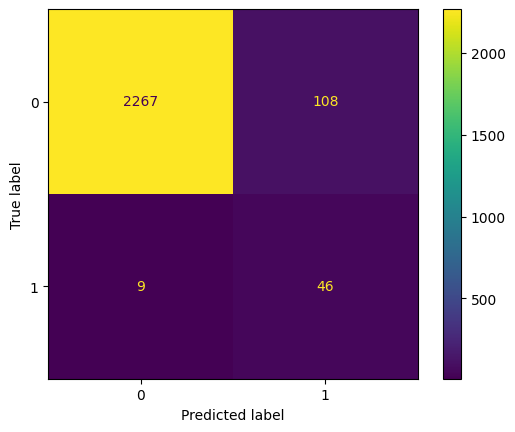

In [58]:
#Making the confusion matrix
y_pred = opt.predict(X_test)
cm = confusion_matrix(y_test, y_pred, labels=opt.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=opt.classes_)
disp.plot()
plt.show()

In [59]:
y_pred = opt.predict(X_test)
y_pred_proba_positive = opt.predict_proba(X_test)[:, 1] #gets predicted probabilities for each patient in X_test belonging to the positive class

#ROC-AUC = model's ability to distinguish between positive + negative classes
#Useful for imbalanced datasets because it considers both true positive + false positive rates
roc_auc_original = roc_auc_score(y_test, y_pred_proba_positive)
print(f"ROC-AUC Score: {roc_auc_original:.4f}")

#F1 score = balance of precision + recall, considers both false positives + false negatives
#'zero_division = 0' = handles cases where division by 0 might occur (e.g. no positive predictions leading to 0 precision/recall)
f1_original = f1_score(y_test, y_pred, zero_division=0)
print(f"F1 Score: {f1_original:.4f}")

#Precision score = measures proportion of positive identifications that were correct
#i.e. when the model predicts mortality, how often is it right
#High precision = low rate of false positives
precision_original = precision_score(y_test, y_pred, zero_division=0)
print(f"Precision Score: {precision_original:.4f}")

#Recall score (sensitivity) = measures proportion of actual positives correctly identified
#i.e. out of all patients who died, how many did the model correctly identify
#High recall = low rate of false negatives
recall_original = recall_score(y_test, y_pred, zero_division=0)
print(f"Recall Score: {recall_original:.4f}")

ROC-AUC Score: 0.9709
F1 Score: 0.4402
Precision Score: 0.2987
Recall Score: 0.8364


## OPTIONAL: Most important features for predicting hospital mortality

In [60]:
xgboost_model = opt.best_estimator_.named_steps['clf'] # Directly access the XGBoost model by its name in the pipeline

#'xgboost_model.get_booster()' = accesses XGBoost model functionalities
#'get_score(importance_type='weight')' = gets feature importance
#'importance_type='weight' = number of times a feature is used in a split across all trees
xgboost_mortality_feature_importances = xgboost_model.get_booster().get_score(importance_type='weight')

feature_importance_df = pd.DataFrame(list(xgboost_mortality_feature_importances.items()), columns=['Feature', 'Importance']) #'xgboost_mortality_feature_importances.items()' = gets key value pairs + converts to a list of tuples w/ feature + importance columns
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False) #sorts dataframe in descending order based on importance column

print("Top 20 Most Influential Features for Mortality Prediction:")
display(feature_importance_df.head(20))

Top 20 Most Influential Features for Mortality Prediction:


,Feature,Importance
85,ER_LoS,54.0
42,'FAC010',36.0
84,age,35.0
34,'RSP012',26.0
41,'NVS020',22.0
6,'FAC025',20.0
51,'INF002',18.0
87,days_since_discharge,18.0
53,'SYM003',16.0
95,admission_location_PHYSICIAN_REFERRAL,15.0


## OPTIONAL: Testing different thresholds

In [61]:
#selects only probabilities for the positive class (mortality)
y_pred_proba = opt.predict_proba(X_test)[:, 1]

#function creates array of evenly spaced values within a given interval
#generates potential thresholds starting from 0.1 to (not including) 0.5 in 0.05 steps
thresholds = np.arange(0.1, 0.5, 0.05)

print("Threshold | Precision | Recall    | F1-Score")
print("----------------------------------------------")

for threshold in thresholds:
    #converts predicted probabilities into binary predictions, if predicted probability of mortality > threshold, they are classed as 1
    #'.astype(int)' = converts boolean array to integer array
    y_pred_threshold = (y_pred_proba >= threshold).astype(int)

    #calculates score at each threshold
    precision = precision_score(y_test, y_pred_threshold, zero_division=0)
    recall = recall_score(y_test, y_pred_threshold)
    f1 = f1_score(y_test, y_pred_threshold)

    print(f"{threshold:.2f}      | {precision:.4f}    | {recall:.4f}    | {f1:.4f}")

Threshold | Precision | Recall    | F1-Score
----------------------------------------------
0.10      | 0.0772    | 1.0000    | 0.1434
0.15      | 0.1032    | 1.0000    | 0.1871
0.20      | 0.1244    | 0.9636    | 0.2204
0.25      | 0.1507    | 0.9455    | 0.2600
0.30      | 0.1731    | 0.8909    | 0.2899
0.35      | 0.1992    | 0.8727    | 0.3243
0.40      | 0.2217    | 0.8545    | 0.3521
0.45      | 0.2527    | 0.8364    | 0.3882


In [62]:
#defining new threshold
new_threshold = 0.2

#get predicted probabilities for the positive class
y_pred_proba_positive = opt.predict_proba(X_test)[:, 1]

#create new binary predictions based on the new threshold
y_pred_new_threshold = (y_pred_proba_positive >= new_threshold).astype(int)

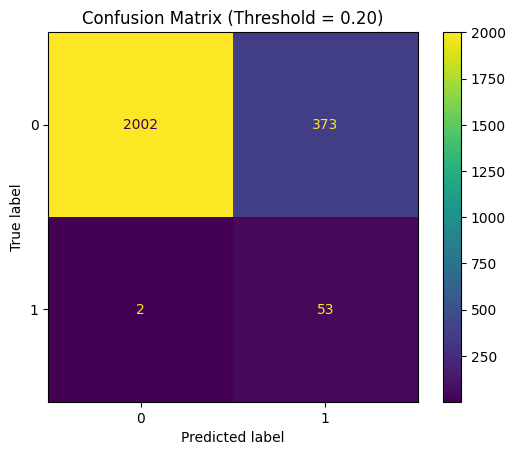

In [63]:
#plotting confusion matrix at new threshold
cm_new = confusion_matrix(y_test, y_pred_new_threshold, labels=opt.classes_)
disp_new = ConfusionMatrixDisplay(confusion_matrix=cm_new, display_labels=opt.classes_)
disp_new.plot()
plt.title(f"Confusion Matrix (Threshold = {new_threshold:.2f})")
plt.show()

In [64]:
#Calculating scores at new threshold
roc_auc = roc_auc_score(y_test, y_pred_proba_positive)
print(f"ROC-AUC Score (unchanged): {roc_auc:.4f}")

f1_new = f1_score(y_test, y_pred_new_threshold, zero_division=0)
print(f"F1 Score (Threshold {new_threshold:.2f}): {f1_new:.4f}")

precision_new = precision_score(y_test, y_pred_new_threshold, zero_division=0)
print(f"Precision Score (Threshold {new_threshold:.2f}): {precision_new:.4f}")

recall_new = recall_score(y_test, y_pred_new_threshold, zero_division=0)
print(f"Recall Score (Threshold {new_threshold:.2f}): {recall_new:.4f}")

ROC-AUC Score (unchanged): 0.9709
F1 Score (Threshold 0.20): 0.2204
Precision Score (Threshold 0.20): 0.1244
Recall Score (Threshold 0.20): 0.9636


#    

# TASK 2: PREDICTING LENGTH OF STAY

## 1) Importing data

In [65]:
testlos = pd.read_csv('test_wide.csv')
trainlos = pd.read_csv('train_wide.csv')

testlos.head()

,hadm_id,'NEO013','NEO070','CIR033','DIG024','EXT025','EXT027','GEN007','END001','DIG004',...,language_Chinese,language_English,language_Russian,language_Spanish,language_Unknown/Other,marital_status_DIVORCED,marital_status_MARRIED,marital_status_SINGLE,marital_status_Unknown/Other,marital_status_WIDOWED
0,23531645,0,0,0,0,0,1,0,0,0,...,0,1,0,0,0,0,1,0,0,0
1,27592458,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0
2,29130275,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0
3,20640976,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0
4,23368528,0,0,0,0,0,1,0,0,0,...,0,1,0,0,0,0,0,1,0,0


## 2) Removing columns impacting length of stay predictions

In [66]:
testlos.drop(['subject_id','hadm_id','days_until_death',
              'hospital_expire_flag'], axis = 1, inplace=True)
trainlos.drop(['subject_id','hadm_id','days_until_death',
               'hospital_expire_flag'], axis = 1, inplace=True)

testlos = testlos[testlos.columns.drop(list(testlos.filter(regex='race')))]
trainlos = trainlos[trainlos.columns.drop(list(trainlos.filter(regex='race')))]

testlos.columns = testlos.columns.str.replace(' ', '_')
trainlos.columns = trainlos.columns.str.replace(' ', '_')

## 3) Formatting data for XGBoost Regression

In [67]:
X_testlos = testlos.drop('LoS', axis=1).copy()
X_trainlos = trainlos.drop('LoS', axis=1).copy()

y_testlos = testlos['LoS'].copy()
y_trainlos = trainlos['LoS'].copy()

X_testlos.head()

,'NEO013','NEO070','CIR033','DIG024','EXT025','EXT027','GEN007','END001','DIG004','FAC025',...,language_Chinese,language_English,language_Russian,language_Spanish,language_Unknown/Other,marital_status_DIVORCED,marital_status_MARRIED,marital_status_SINGLE,marital_status_Unknown/Other,marital_status_WIDOWED
0,0,0,0,0,0,1,0,0,0,1,...,0,1,0,0,0,0,1,0,0,0
1,0,0,0,0,0,0,0,0,0,2,...,0,1,0,0,0,0,0,1,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0
3,0,0,0,0,0,0,0,0,0,1,...,0,1,0,0,0,0,0,1,0,0
4,0,0,0,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0


## 4) Designing pipeline for the regression model

In [68]:
losestimators = [
    ('target_encoder', TargetEncoder()),
    ('clf', XGBRegressor(random_state=67))
]
pipe = Pipeline(steps=losestimators)
pipe

Pipeline(steps=[('target_encoder', TargetEncoder()),
                ('clf',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsample_bynode=None,
                              colsample_bytree=None, device=None,
                              early_stopping_rounds=None,
                              enable_categorical=False, eval_metric=None,
                              feature_types=None, feature_weights=None,
                              gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=None, n_jobs=None,
                              num_parallel_tree=None, ...))])

## 5) Hyperparameter tuning

In [69]:
lossearch_space = {
    'clf__max_depth': Integer(2,8),
    'clf__learning_rate': Real(0.001, 1.0, prior='log-uniform'),
    'clf__subsample': Real(0.5, 1.0),
    'clf__colsample_bytree': Real(0.5, 1.0),
    'clf__colsample_bylevel': Real(0.5, 1.0),
    'clf__colsample_bynode' : Real(0.5, 1.0),
    'clf__reg_alpha': Real(0.0, 10.0),
    'clf__reg_lambda': Real(0.0, 10.0),
    'clf__gamma': Real(0.0, 10.0)
}

losopt = BayesSearchCV(pipe, lossearch_space,
                       cv=10,
                       n_iter=10,
                       scoring='neg_mean_squared_error', #BayesSearchCV expects scoring metrics to be maximised, since MSE is a loss metric (lower is better), we take the negative so BayesSearchCV can maximise it to effectively find combination of hyperparameters that minimises actual MSE
                       verbose=1, #prints progress messages during optimisation
                       random_state=67)

## 6) Training the model

In [70]:
losopt.fit(X_trainlos, y_trainlos)

Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits


BayesSearchCV(cv=10,
              estimator=Pipeline(steps=[('target_encoder', TargetEncoder()),
                                        ('clf',
                                         XGBRegressor(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      device=None,
                                                      early_stopping_rounds=None,
                                                      enable_categorical=False,
                                                      eval_metric=None,
                                                      feature_types=None,
                                                      feature_weights=None,
                                                      gamma=None,
                                                      grow_p...
                             'clf__learning_rate': Real(low=0.001, high=1.0, prior='log-uniform', transform='normalize'),
                             'clf__max_depth': Integer(low=2, high=8, prior='uniform', transform='normalize'),
                             'clf__reg_alpha': Real(low=0.0, high=10.0, prior='uniform', transform='normalize'),
                             'clf__reg_lambda': Real(low=0.0, high=10.0, prior='uniform', transform='normalize'),
                             'clf__subsample': Real(low=0.5, high=1.0, prior='uniform', transform='normalize')},
              verbose=1)

In [71]:
#Fully trained regression model
losopt.best_estimator_

losopt.best_estimator_.steps

[('target_encoder', TargetEncoder(cols=[])),
 ('clf',
  XGBRegressor(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=0.5401244070675608,
               colsample_bynode=0.8954946751119793,
               colsample_bytree=0.5734729873192601, device=None,
               early_stopping_rounds=None, enable_categorical=False,
               eval_metric=None, feature_types=None, feature_weights=None,
               gamma=6.587698217469077, grow_policy=None, importance_type=None,
               interaction_constraints=None, learning_rate=0.29990651684642206,
               max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=3, max_leaves=None,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               multi_strategy=None, n_estimators=None, n_jobs=None,
               num_parallel_tree=None, ...))]

In [72]:
#Mean squared error for the length of stay
#Take absolute value (34.905)
#Closer to 0 = better performance
#Consider root mean squared error (RMSE) which is the square root of MSE
#RMSE = 5.91, means on average the models predictions for LoS are off by ~6.82 days
losopt.best_score_

np.float64(-34.90586879565026)

## 7) Testing the model on the test data

In [73]:
#RMSE = 5.58
losopt.score(X_testlos, y_testlos)

-31.095930047903497

In [74]:
#Model's LoS predictions for the test data
#Consists of LoS values in days for each patient in the test data
losopt.predict(X_testlos)

array([7.1431837, 8.550057 , 2.8906062, ..., 6.951214 , 5.426908 ,
       2.6254396], dtype=float32)

In [75]:
y_pred_best_los = losopt.best_estimator_.predict(X_testlos)

mse = mean_squared_error(y_testlos, y_pred_best_los)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_testlos, y_pred_best_los)
r2 = r2_score(y_testlos, y_pred_best_los)

#Large errors contribute more to total error than smaller ones
#Much more sensitive to outliers
#Difficult to interpret so use RMSE which is more interpretable
#More difficult to interpret due to being outlier-heavy
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")

#Less sensitive to outliers compared to MSE
#Large error contributes proportionally to total error (few large errors won't disproportionately inflate the MAE)
#Easy to interpret
print(f"Mean Absolute Error (MAE): {mae:.4f}")

#Represents proportion of the variance in the dependent variable (LoS) that can be predicted from the independent variables (features)
#Score of 1 = model explains all variability of the target variable
#Higher score = better fit
print(f"R-squared (R2 Score): {r2:.4f}")

Mean Squared Error (MSE): 31.0959
Root Mean Squared Error (RMSE): 5.5764
Mean Absolute Error (MAE): 2.7456
R-squared (R2 Score): 0.4075


## OPTIONAL: Most important features for predicting hospital mortality



In [76]:
losxgboost_model = losopt.best_estimator_.named_steps['clf']
feature_importances = losxgboost_model.get_booster().get_score(importance_type='weight')

importance_df = pd.DataFrame(list(feature_importances.items()), columns=['Feature', 'Importance'])

importance_df = importance_df.sort_values(by='Importance', ascending=False)

print("Feature Importances for Length of Stay Prediction (Top 20):")
display(importance_df.head(20))

Feature Importances for Length of Stay Prediction (Top 20):


,Feature,Importance
164,days_since_discharge,26.0
162,ER_LoS,17.0
37,'BLD006',15.0
25,'END008',15.0
36,'END011',12.0
77,'INF002',12.0
154,'NVS002',12.0
46,'NVS009',11.0
161,age,11.0
7,'FAC025',10.0


##    

# TASK 3a: EXPLORING WHETHER DIFFERENT ETHNIC GROUPS IMPACT PREDICTION PERFORMANCE (HOSPITAL MORTALITY)

## 1) Importing data



In [77]:
raw_test_df = pd.read_csv('test_wide.csv')

raw_test_df.head()

,hadm_id,'NEO013','NEO070','CIR033','DIG024','EXT025','EXT027','GEN007','END001','DIG004',...,language_Chinese,language_English,language_Russian,language_Spanish,language_Unknown/Other,marital_status_DIVORCED,marital_status_MARRIED,marital_status_SINGLE,marital_status_Unknown/Other,marital_status_WIDOWED
0,23531645,0,0,0,0,0,1,0,0,0,...,0,1,0,0,0,0,1,0,0,0
1,27592458,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0
2,29130275,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0
3,20640976,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0
4,23368528,0,0,0,0,0,1,0,0,0,...,0,1,0,0,0,0,0,1,0,0


## 2) Removing columns impacting hospital mortality prediction



In [78]:
X_test_for_prediction = raw_test_df.copy()

y_test_full = raw_test_df['hospital_expire_flag'].copy()

X_test_for_prediction.drop(['subject_id','hadm_id','days_until_death','LoS',
           'hospital_expire_flag'], axis = 1, inplace=True)

X_test_for_prediction = X_test_for_prediction[X_test_for_prediction.columns.drop(list(X_test_for_prediction.filter(regex='race')))]

X_test_for_prediction.columns = X_test_for_prediction.columns.str.replace(' ', '_')

X_test_for_prediction.head()


,'NEO013','NEO070','CIR033','DIG024','EXT025','EXT027','GEN007','END001','DIG004','FAC025',...,language_Chinese,language_English,language_Russian,language_Spanish,language_Unknown/Other,marital_status_DIVORCED,marital_status_MARRIED,marital_status_SINGLE,marital_status_Unknown/Other,marital_status_WIDOWED
0,0,0,0,0,0,1,0,0,0,1,...,0,1,0,0,0,0,1,0,0,0
1,0,0,0,0,0,0,0,0,0,2,...,0,1,0,0,0,0,0,1,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0
3,0,0,0,0,0,0,0,0,0,1,...,0,1,0,0,0,0,0,1,0,0
4,0,0,0,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0


## 3) Setting threshold

In [79]:
y_pred_proba_full = opt.best_estimator_.predict_proba(X_test_for_prediction)[:, 1]
y_pred_full_binary = (y_pred_proba_full >= 0.5).astype(int)

## 4) Creating dataframe for model performance comparison between different ethnicities

In [80]:
#Dataframe includes true labels, predicted probabilities, binary predictions + race information to compare model performance
analysis_df = raw_test_df.copy()

analysis_df['true_label'] = y_test_full
analysis_df['predicted_proba'] = y_pred_proba_full
analysis_df['predicted_binary'] = y_pred_full_binary

analysis_df.head()

,hadm_id,'NEO013','NEO070','CIR033','DIG024','EXT025','EXT027','GEN007','END001','DIG004',...,language_Spanish,language_Unknown/Other,marital_status_DIVORCED,marital_status_MARRIED,marital_status_SINGLE,marital_status_Unknown/Other,marital_status_WIDOWED,true_label,predicted_proba,predicted_binary
0,23531645,0,0,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0.281662,0
1,27592458,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0.164370,0
2,29130275,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0.016691,0
3,20640976,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0.021979,0
4,23368528,0,0,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0.003637,0


In [82]:
#Identifying all columns representing ethnic groups (race) to compare performance
race_columns = [col for col in raw_test_df.columns if col.startswith('race_')]
print(race_columns)

['race_ASIAN', 'race_ASIAN - CHINESE', 'race_BLACK/AFRICAN AMERICAN', 'race_BLACK/CAPE VERDEAN', 'race_HISPANIC OR LATINO', 'race_HISPANIC/LATINO - DOMINICAN', 'race_HISPANIC/LATINO - PUERTO RICAN', 'race_Unknown/Other', 'race_WHITE', 'race_WHITE - RUSSIAN']


## 5) Comparing model performance by ethnic group



In [89]:
print("\nModel Performance by Ethnic Group:\n")

#Initialising empty list to store dictoinaries containing performance metrics for different ethnic groups
results = []

#Loop through each column stored in 'race_columns'
for race_col in race_columns:
    #Filters the dataframe to only select rows where the value of the current race column is 1 (isolates patients belonging to the specific ethnic group)
    group_df = analysis_df[analysis_df[race_col] == 1].copy()

    #Checks if the filtered 'group_df' is not empty
    #If no patients belong to a group, it skips calculating metrics to avoid errors
    if not group_df.empty:
        true_labels_group = group_df['true_label']
        pred_proba_group = group_df['predicted_proba']
        pred_binary_group = group_df['predicted_binary']

        #Calculating metrics for the current group
        #ROC-AUC requires at least two unique classes in true_labels_group
        if true_labels_group.nunique() > 1:
            roc_auc_group = roc_auc_score(true_labels_group, pred_proba_group)
        else:
            roc_auc_group = np.nan #Assign NaN if ROC-AUC is undefined

        precision_group = precision_score(true_labels_group, pred_binary_group, zero_division=0)
        recall_group = recall_score(true_labels_group, pred_binary_group, zero_division=0)
        f1_group = f1_score(true_labels_group, pred_binary_group, zero_division=0)

        #Dictionary that calculates scores for each race + adds it to the 'results' list
        results.append({
            'Ethnic Group': race_col.replace('race_', ''),
            'ROC-AUC': roc_auc_group,
            'Precision': precision_group,
            'Recall': recall_group,
            'F1-Score': f1_group
        })

    #If 'group_df' is empty (no patient in the ethnic group), the dictionary is appended to 'results' w/ np.nan for all metrics
    else:
        results.append({
            'Ethnic Group': race_col.replace('race_', ''),
            'ROC-AUC': np.nan,
            'Precision': np.nan,
            'Recall': np.nan,
            'F1-Score': np.nan
        })

#When all metrics collected, the list of dictionaries is converted to a pandas Dataframe (easy to read)
performance_df = pd.DataFrame(results)
print(performance_df.to_string())


Model Performance by Ethnic Group:

                     Ethnic Group   ROC-AUC  Precision    Recall  F1-Score
0                           ASIAN  0.962963   0.500000  0.500000  0.500000
1                 ASIAN - CHINESE       NaN   0.000000  0.000000  0.000000
2          BLACK/AFRICAN AMERICAN  0.971847   0.181818  0.666667  0.285714
3              BLACK/CAPE VERDEAN       NaN   0.000000  0.000000  0.000000
4              HISPANIC OR LATINO       NaN   0.000000  0.000000  0.000000
5     HISPANIC/LATINO - DOMINICAN  1.000000   0.500000  1.000000  0.666667
6  HISPANIC/LATINO - PUERTO RICAN       NaN   0.000000  0.000000  0.000000
7                   Unknown/Other  0.976528   0.342105  1.000000  0.509804
8                           WHITE  0.968884   0.301075  0.800000  0.437500
9                 WHITE - RUSSIAN  1.000000   0.500000  1.000000  0.666667


## Summary:

### Q&A
The model's prediction performance shows significant disparities across ethnic groups. While some groups exhibit high discriminative ability (ROC-AUC), precision is generally low across all groups. This indicates a high rate of false positives, meaning many patients predicted to die do not. Recall is often high, suggesting the model identifies a large proportion of actual mortality cases.

Implications include potential model bias or disparate impact due to varying performance. The choice of a 0.025 threshold prioritizes recall, leading to low precision. Data imbalance or insufficient representation of smaller ethnic groups in the test set also affects metric reliability for these subgroups.

### Data Analysis Key Findings
*   **ROC-AUC Variation**: ROC-AUC scores varied significantly, from 0.722 for 'ASIAN' to 0.974 for 'BLACK/AFRICAN AMERICAN' and 1.000 for 'HISPANIC/LATINO - DOMINICAN', indicating differences in discriminative power.
*   **Low Precision**: Precision scores were generally low across all groups, ranging from 0.000 to 0.500. For example, 'BLACK/AFRICAN AMERICAN' had a precision of 0.068 despite a high ROC-AUC.
*   **High Recall**: Recall was high for many groups where positive cases existed, often 0.500 or 1.000 (e.g., 'BLACK/AFRICAN AMERICAN', 'HISPANIC/LATINO - DOMINICAN', 'WHITE'), suggesting the model effectively captures most mortality events.
*   **Low F1-Scores**: F1-scores were generally low due to poor precision, with the highest for 'HISPANIC/LATINO - DOMINICAN' at 0.667. Other groups like 'ASIAN' (0.286), 'BLACK/AFRICAN AMERICAN' (0.128), and 'WHITE' (0.188) had considerably lower F1-scores.
*   **Undefined Metrics for Small Groups**: Several groups (e.g., 'ASIAN - CHINESE', 'BLACK/CAPE VERDEAN') had NaN for ROC-AUC and 0.000 for other metrics, indicating very few or no mortality events in the test set for these subgroups, making reliable evaluation challenging.

### Insights or Next Steps
*   Investigate data representation and distribution of mortality events across ethnic groups in both training and test datasets to address potential underrepresentation.
*   Re-evaluate the prediction threshold or explore dynamic thresholds tailored for different ethnic groups to balance precision and recall more effectively.


##  

# TASK 3b: EXPLORING WHETHER DIFFERENT ETHNIC GROUPS IMPACT PREDICTION PERFORMANCE (LENGTH OF STAY)

## 1) Importing data

In [90]:
raw_test_df_los = pd.read_csv('test_wide.csv')

raw_test_df_los.head()

,hadm_id,'NEO013','NEO070','CIR033','DIG024','EXT025','EXT027','GEN007','END001','DIG004',...,language_Chinese,language_English,language_Russian,language_Spanish,language_Unknown/Other,marital_status_DIVORCED,marital_status_MARRIED,marital_status_SINGLE,marital_status_Unknown/Other,marital_status_WIDOWED
0,23531645,0,0,0,0,0,1,0,0,0,...,0,1,0,0,0,0,1,0,0,0
1,27592458,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0
2,29130275,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0
3,20640976,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0
4,23368528,0,0,0,0,0,1,0,0,0,...,0,1,0,0,0,0,0,1,0,0


## 2) Removing columns impacting length of stay predictions

In [91]:
X_test_for_prediction_los = raw_test_df_los.copy()
y_test_full_los = raw_test_df_los['LoS'].copy()

X_test_for_prediction_los.drop(['subject_id', 'hadm_id', 'days_until_death',
                                'hospital_expire_flag', 'LoS'],
                                axis=1, inplace=True)

X_test_for_prediction_los = X_test_for_prediction_los[X_test_for_prediction_los.columns.drop(list(X_test_for_prediction_los.filter(regex='race')))]

X_test_for_prediction_los.columns = X_test_for_prediction_los.columns.str.replace(' ', '_')

X_test_for_prediction_los.head()

,'NEO013','NEO070','CIR033','DIG024','EXT025','EXT027','GEN007','END001','DIG004','FAC025',...,language_Chinese,language_English,language_Russian,language_Spanish,language_Unknown/Other,marital_status_DIVORCED,marital_status_MARRIED,marital_status_SINGLE,marital_status_Unknown/Other,marital_status_WIDOWED
0,0,0,0,0,0,1,0,0,0,1,...,0,1,0,0,0,0,1,0,0,0
1,0,0,0,0,0,0,0,0,0,2,...,0,1,0,0,0,0,0,1,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0
3,0,0,0,0,0,0,0,0,0,1,...,0,1,0,0,0,0,0,1,0,0
4,0,0,0,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0


## 3) Getting predicted length of stay values



In [92]:
y_pred_full_los = losopt.best_estimator_.predict(X_test_for_prediction_los)

## 4) Creating dataframe for model performance comparison between different ethnicities

In [93]:
analysis_df_los = raw_test_df_los.copy()
analysis_df_los['true_los'] = y_test_full_los
analysis_df_los['predicted_los'] = y_pred_full_los

print("Combined DataFrame for LoS analysis created.")
analysis_df_los.head()

Combined DataFrame for LoS analysis created.


,hadm_id,'NEO013','NEO070','CIR033','DIG024','EXT025','EXT027','GEN007','END001','DIG004',...,language_Russian,language_Spanish,language_Unknown/Other,marital_status_DIVORCED,marital_status_MARRIED,marital_status_SINGLE,marital_status_Unknown/Other,marital_status_WIDOWED,true_los,predicted_los
0,23531645,0,0,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,3.136111,7.143184
1,27592458,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,5.052083,8.550057
2,29130275,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,4.653472,2.890606
3,20640976,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,4.625000,2.890606
4,23368528,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,1.622222,0.481741


In [94]:
race_columns_los = [col for col in raw_test_df_los.columns if col.startswith('race_')]
print(race_columns_los)

['race_ASIAN', 'race_ASIAN - CHINESE', 'race_BLACK/AFRICAN AMERICAN', 'race_BLACK/CAPE VERDEAN', 'race_HISPANIC OR LATINO', 'race_HISPANIC/LATINO - DOMINICAN', 'race_HISPANIC/LATINO - PUERTO RICAN', 'race_Unknown/Other', 'race_WHITE', 'race_WHITE - RUSSIAN']


## 5) Comparing model performance by ethnic group



In [95]:
print("\nLoS Model Performance by Ethnic Group:\n")

los_results = []

for race_col in race_columns_los:
    # Filter data for the current ethnic group
    group_df_los = analysis_df_los[analysis_df_los[race_col] == 1].copy()

    if not group_df_los.empty:
        true_los_group = group_df_los['true_los']
        predicted_los_group = group_df_los['predicted_los']

        # Calculate metrics for the current group
        mse_group = mean_squared_error(true_los_group, predicted_los_group)
        rmse_group = np.sqrt(mse_group)
        mae_group = mean_absolute_error(true_los_group, predicted_los_group)
        r2_group = r2_score(true_los_group, predicted_los_group)

        los_results.append({
            'Ethnic Group': race_col.replace('race_', ''),
            'MSE': mse_group,
            'RMSE': rmse_group,
            'MAE': mae_group,
            'R2-Score': r2_group
        })
    else:
        los_results.append({
            'Ethnic Group': race_col.replace('race_', ''),
            'MSE': np.nan,
            'RMSE': np.nan,
            'MAE': np.nan,
            'R2-Score': np.nan
        })

performance_df_los = pd.DataFrame(los_results)
print(performance_df_los.to_string())



LoS Model Performance by Ethnic Group:

                     Ethnic Group        MSE      RMSE       MAE  R2-Score
0                           ASIAN  44.480729  6.669387  3.004270  0.226848
1                 ASIAN - CHINESE  32.639448  5.713094  2.839288 -1.513878
2          BLACK/AFRICAN AMERICAN   8.011298  2.830424  1.849176  0.395108
3              BLACK/CAPE VERDEAN   1.749488  1.322682  0.903528  0.401967
4              HISPANIC OR LATINO   9.055154  3.009178  1.944287  0.372673
5     HISPANIC/LATINO - DOMINICAN   6.271764  2.504349  2.049807  0.248893
6  HISPANIC/LATINO - PUERTO RICAN  11.807696  3.436233  2.235722  0.640847
7                   Unknown/Other  74.454778  8.628718  3.609246  0.435161
8                           WHITE  27.568316  5.250554  2.789784  0.389623
9                 WHITE - RUSSIAN   7.409483  2.722037  2.160902  0.429556
